In [200]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [201]:
from stockMarket.predictions import InputData
from stockMarket.core import get_tickers_from_index, contracts_to_df
from stockMarket.core import Technicals

microsoft = Technicals(ticker='MSFT')
microsoft.init_pricing_data(interval="daily", n_bars=2000)

In [202]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

price = np.log(microsoft.pricing_data[["close"]])
print(price.shape)

scaler = MinMaxScaler(feature_range=(-1,1))
price["close"] = scaler.fit_transform(price["close"].values.reshape(-1,1))
print(price.shape)

dataset = price.values

test_set_size = int(np.round(0.2*dataset.shape[0]))
train_set_size = dataset.shape[0] - (test_set_size)

train = dataset[:train_set_size,:]
print(train.shape)

test = dataset[train_set_size:,:]
print(test.shape)

(2000, 1)
(2000, 1)
(1600, 1)
(400, 1)


In [203]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 30
x_train, y_train, x_test, y_test = split_data(price, lookback)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1576, 29, 1)
(1576, 1)
(394, 29, 1)
(394, 1)


In [204]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [205]:
input_dim = 1
hidden_dim = 16
num_layers = 3
output_dim = 1
num_epochs = 500

In [206]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) #2
        out = self.fc(out[:, -1, :]) 
        return out

In [207]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [208]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.29481232166290283
Epoch  1 MSE:  0.2833637595176697
Epoch  2 MSE:  0.28317394852638245
Epoch  3 MSE:  0.27775701880455017
Epoch  4 MSE:  0.26714569330215454
Epoch  5 MSE:  0.2514898180961609
Epoch  6 MSE:  0.22328007221221924
Epoch  7 MSE:  0.16966022551059723
Epoch  8 MSE:  0.09739312529563904
Epoch  9 MSE:  0.04843207448720932
Epoch  10 MSE:  0.040142085403203964
Epoch  11 MSE:  0.05385603755712509
Epoch  12 MSE:  0.07942754775285721
Epoch  13 MSE:  0.057233985513448715
Epoch  14 MSE:  0.03913881257176399
Epoch  15 MSE:  0.028699614107608795
Epoch  16 MSE:  0.026339879259467125
Epoch  17 MSE:  0.028752434998750687
Epoch  18 MSE:  0.0327167734503746
Epoch  19 MSE:  0.03518414497375488
Epoch  20 MSE:  0.033804960548877716
Epoch  21 MSE:  0.028857706114649773
Epoch  22 MSE:  0.02309437282383442
Epoch  23 MSE:  0.018499193713068962
Epoch  24 MSE:  0.014161328785121441
Epoch  25 MSE:  0.01183124165982008
Epoch  26 MSE:  0.013283834792673588
Epoch  27 MSE:  0.0135740386322

In [209]:
import matplotlib.pyplot as plt
import pandas as pd

actuals = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))
print(actuals.head())
preds = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
print(preds.head())

          0
0  4.011507
1  4.017643
2  4.015121
3  3.999301
4  4.009512
          0
0  3.997926
1  4.001896
2  4.006516
3  4.010579
4  4.011874


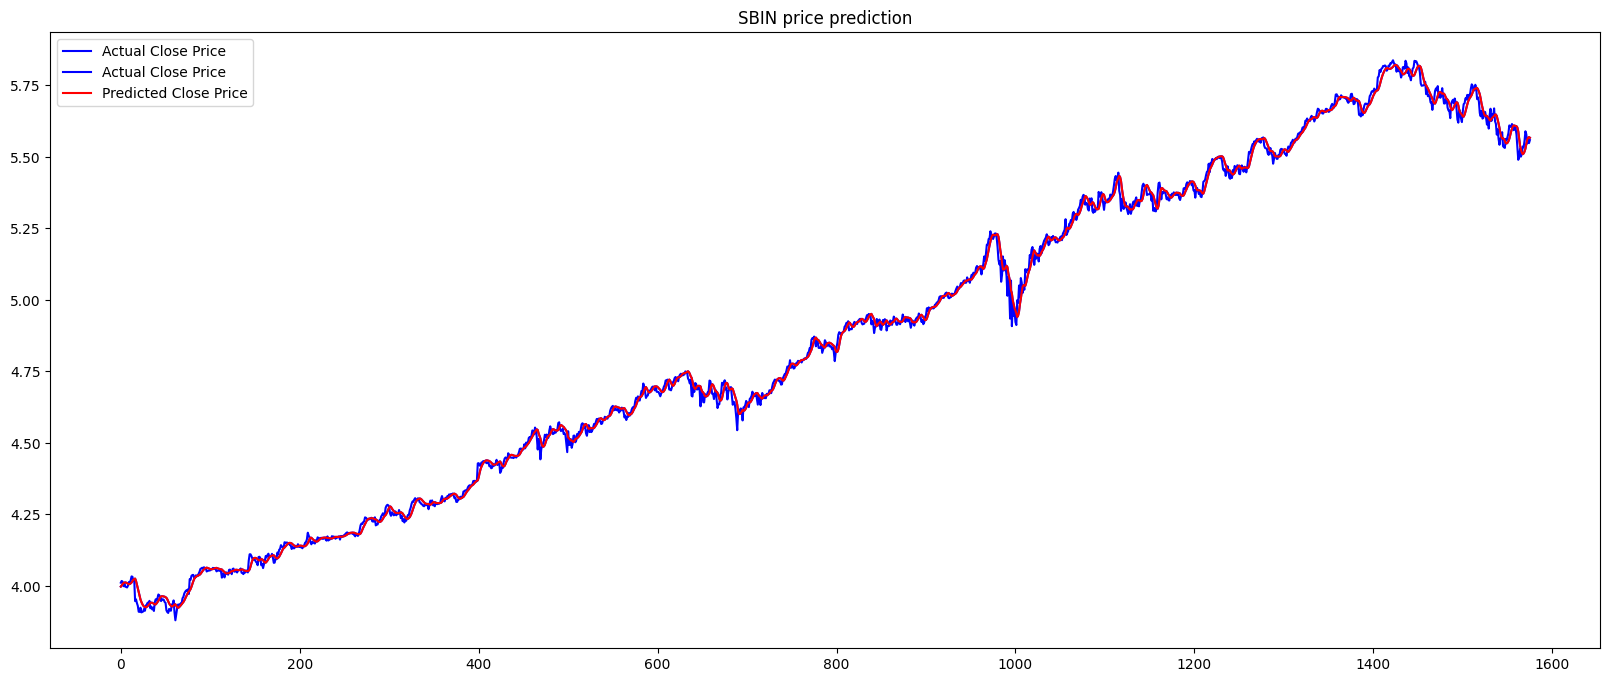

In [210]:
train = price[0:len(actuals)]
valid = actuals
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(valid, color = 'blue', label = 'Actual Close Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Close Price')
plt.title('SBIN price prediction')
plt.legend()
plt.show()

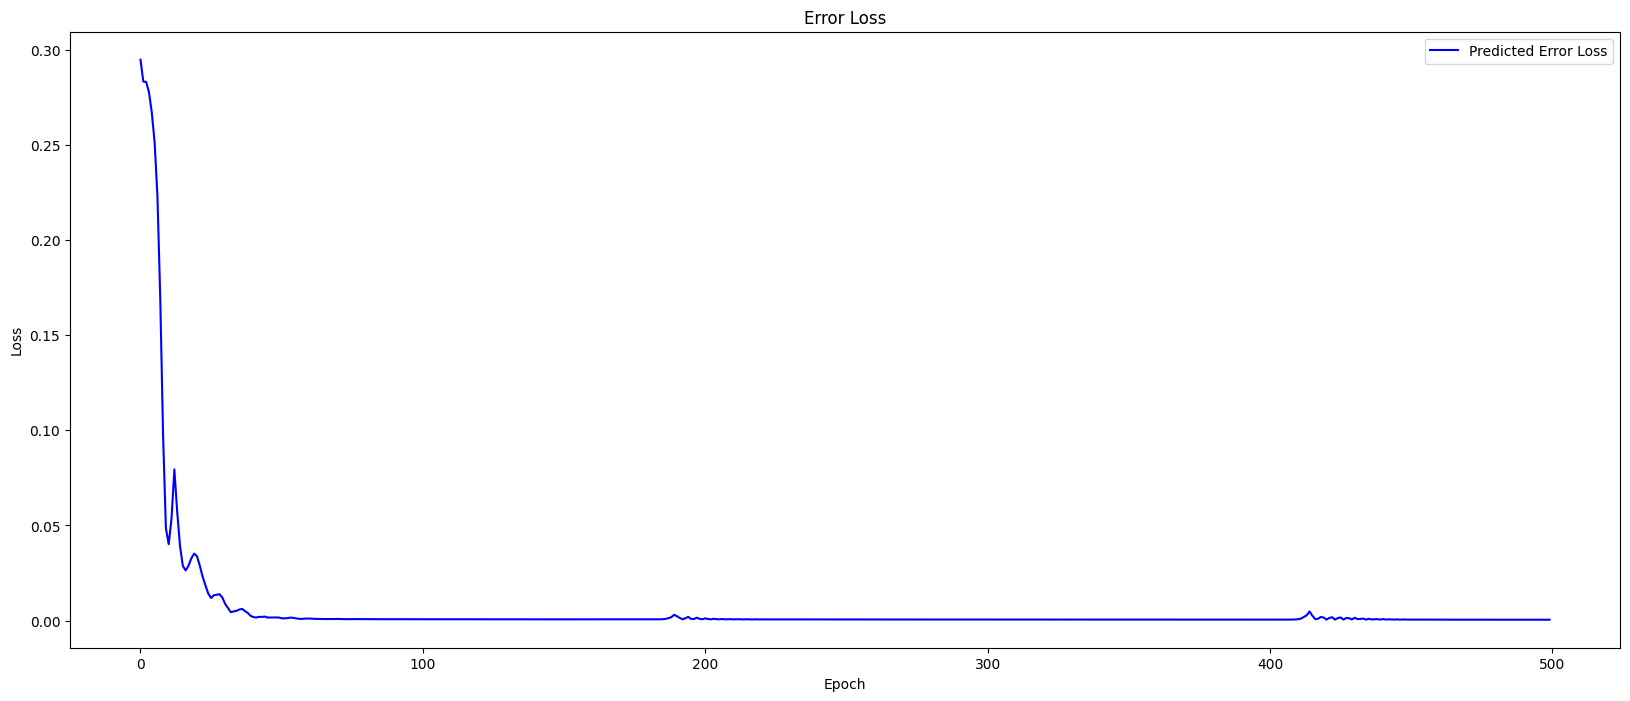

In [211]:
epochs = np.arange(num_epochs)
plt.figure(figsize=(20,8))
plt.plot(epochs, hist, color = 'blue', label = 'Predicted Error Loss')
plt.title('Error Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [212]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())

y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

In [213]:
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 0.02 RMSE
Test Score: 0.03 RMSE


Actual Close Scalar
          0
0  3.954891
1  3.947776
2  3.963666
3  3.935349
4  3.938860
Predicted Close Scalar
          0
0  5.564806
1  5.565261
2  5.569516
3  5.576492
4  5.583186


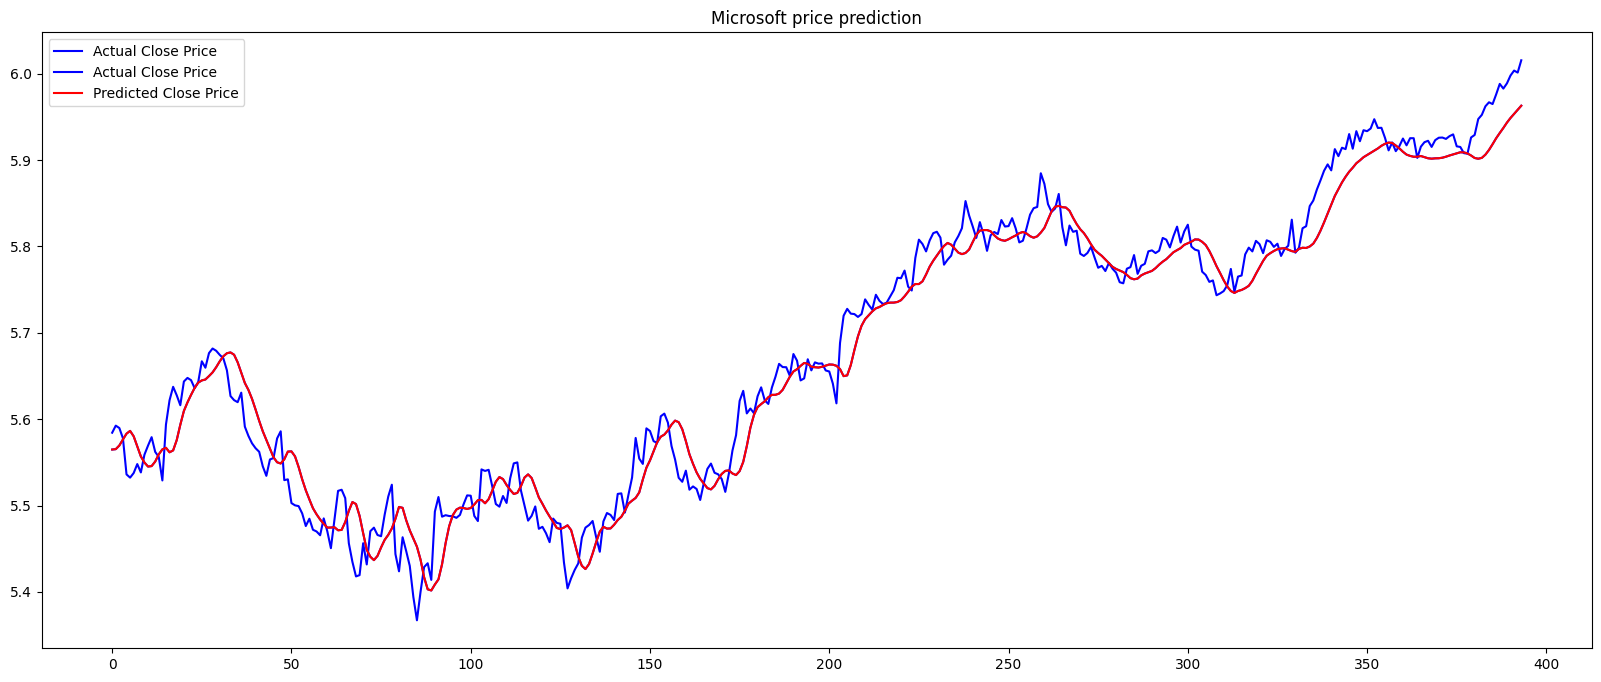

In [214]:
#Shift test predictions for plotting
original = scaler.inverse_transform(price['close'].values.reshape(-1,1))
actuals = pd.DataFrame(original)
print("Actual Close Scalar")
print(actuals.head())
preds = pd.DataFrame(y_test_pred)
print("Predicted Close Scalar")
print(preds.head())

#Prepare actual close entries
aScalar = actuals[len(price) - len(preds):len(price)]

#Reset indexes for actuals for last 1037 entries
aScalar = aScalar.reset_index(drop=True)

#Plot predictions/actuals close price for test entries
valid = aScalar
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(valid, color = 'blue', label = 'Actual Close Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Close Price')
plt.title('Microsoft price prediction')
plt.legend()
plt.show()

In [215]:
save_model = "predict_stock_price_using_lstm_in_pytorch"
torch.save(model.state_dict(), save_model)
list(model.parameters())

[Parameter containing:
 tensor([[-0.0283],
         [ 0.2365],
         [ 0.1757],
         [-0.1288],
         [-0.1074],
         [ 0.1858],
         [ 0.2604],
         [ 0.1076],
         [-0.0899],
         [ 0.2929],
         [ 0.3396],
         [-0.2993],
         [-0.2775],
         [-0.3161],
         [-0.2617],
         [-0.2087],
         [-0.3359],
         [ 0.0934],
         [ 0.0663],
         [-0.0838],
         [ 0.0957],
         [ 0.5316],
         [-0.0184],
         [-0.3179],
         [-0.1625],
         [ 0.0660],
         [ 0.1697],
         [-0.1374],
         [ 0.0147],
         [ 0.0181],
         [ 0.1041],
         [-0.2123],
         [ 0.1890],
         [-0.1987],
         [-0.0015],
         [ 0.2947],
         [-0.2847],
         [-0.2366],
         [ 0.2275],
         [-0.4179],
         [-0.3588],
         [-0.3771],
         [-0.3972],
         [-0.3369],
         [ 0.2889],
         [-0.2964],
         [ 0.3632],
         [ 0.3830],
         [-0.0974

In [216]:
saved_model = "predict_stock_price_using_lstm_in_pytorch"
model2 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model2.load_state_dict(torch.load(saved_model))
model2.eval()
list(model.parameters())

[Parameter containing:
 tensor([[-0.0283],
         [ 0.2365],
         [ 0.1757],
         [-0.1288],
         [-0.1074],
         [ 0.1858],
         [ 0.2604],
         [ 0.1076],
         [-0.0899],
         [ 0.2929],
         [ 0.3396],
         [-0.2993],
         [-0.2775],
         [-0.3161],
         [-0.2617],
         [-0.2087],
         [-0.3359],
         [ 0.0934],
         [ 0.0663],
         [-0.0838],
         [ 0.0957],
         [ 0.5316],
         [-0.0184],
         [-0.3179],
         [-0.1625],
         [ 0.0660],
         [ 0.1697],
         [-0.1374],
         [ 0.0147],
         [ 0.0181],
         [ 0.1041],
         [-0.2123],
         [ 0.1890],
         [-0.1987],
         [-0.0015],
         [ 0.2947],
         [-0.2847],
         [-0.2366],
         [ 0.2275],
         [-0.4179],
         [-0.3588],
         [-0.3771],
         [-0.3972],
         [-0.3369],
         [ 0.2889],
         [-0.2964],
         [ 0.3632],
         [ 0.3830],
         [-0.0974

In [217]:
apple = Technicals(ticker='AAPL')
apple.init_pricing_data(interval="daily", n_bars=2000)
paypal = Technicals(ticker='PYPL')
paypal.init_pricing_data(interval="daily", n_bars=2000)

apple_price = np.log(apple.pricing_data[["close"]])
paypal_price = np.log(paypal.pricing_data[["close"]])
scaler = MinMaxScaler(feature_range=(-1,1))
apple_price["close"] = scaler.fit_transform(apple_price["close"].values.reshape(-1,1))
paypal_price["close"] = scaler.fit_transform(paypal_price["close"].values.reshape(-1,1))

In [218]:
def test_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    # create all possible window length
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    x_test = data[:,:-1]
    y_test = data[:,-1,:]
    
    return [x_test, y_test]

In [219]:
lookback = 30
x_test_apple,  y_test_apple = test_data(apple_price, lookback)
x_test_paypal, y_test_paypal = test_data(paypal_price, lookback)
x_test_apple = torch.from_numpy( x_test_apple).type(torch.Tensor)
x_test_paypal = torch.from_numpy(x_test_paypal).type(torch.Tensor)
y_test_apple = torch.from_numpy( y_test_apple).type(torch.Tensor)
y_test_paypal = torch.from_numpy(y_test_paypal).type(torch.Tensor)

In [220]:
y_test_pred_apple = model2( x_test_apple)
y_test_pred_paypal = model2(x_test_paypal)

# invert predictions
y_test_pred_apple = scaler.inverse_transform(y_test_pred_apple.detach().numpy())
y_test_pred_paypal = scaler.inverse_transform(y_test_pred_paypal.detach().numpy())
y_test_apple = scaler.inverse_transform(y_test_apple.detach().numpy())
y_test_paypal = scaler.inverse_transform(y_test_paypal.detach().numpy())

# calculate root mean squared error
testScore_apples = math.sqrt(mean_squared_error(y_test_apple[:,0], y_test_pred_apple[:,0]))
testScore_paypal = math.sqrt(mean_squared_error(y_test_paypal[:,0], y_test_pred_paypal[:,0]))

(2000, 1)
(1970, 1)


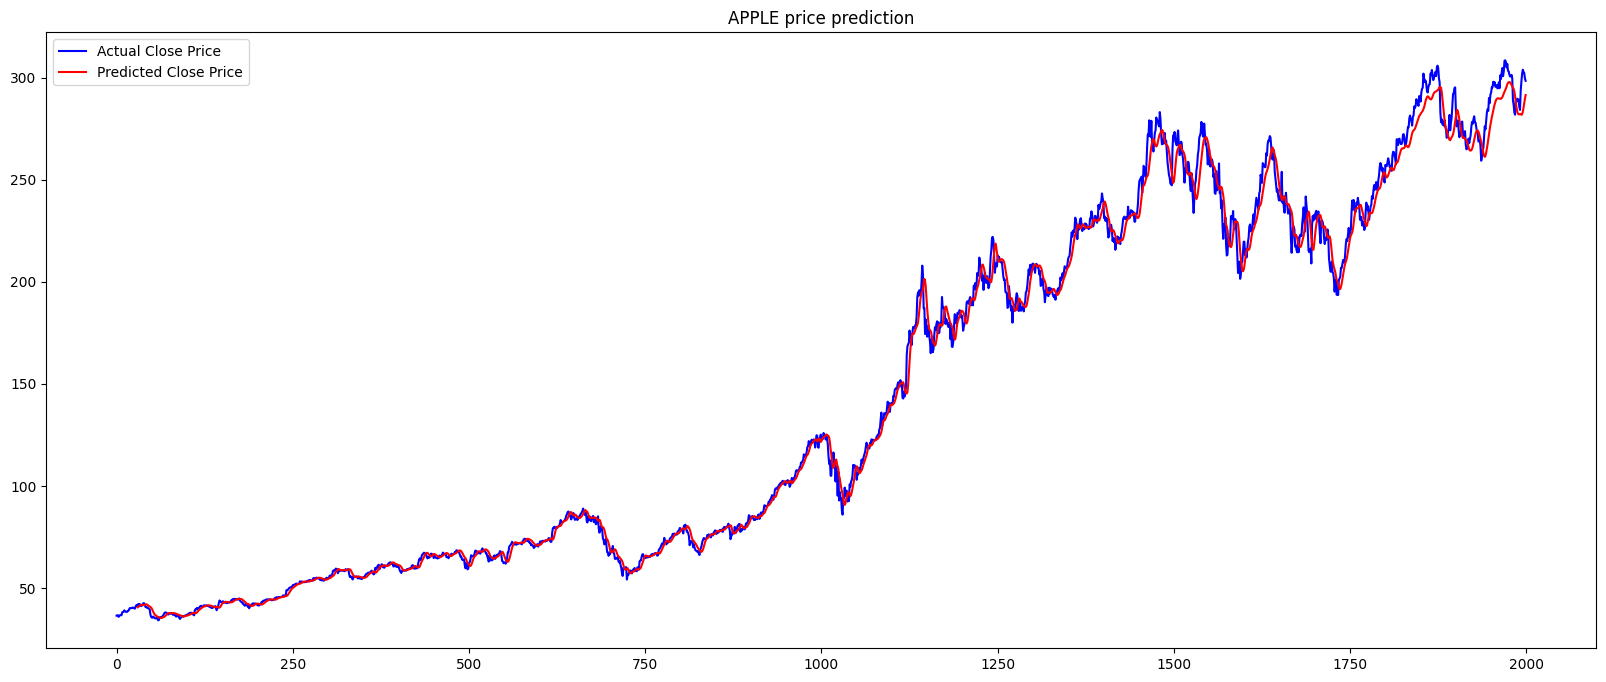

In [224]:
original = scaler.inverse_transform(apple_price['close'].values.reshape(-1,1))
actuals = pd.DataFrame(original)
predictions = pd.DataFrame(y_test_pred_apple)

#Plot predictions/actuals close price for test entries
valid['Actual'] = actuals
valid['Predictions'] = predictions
print(actuals.shape)
print(predictions.shape)
predictions.index = predictions.index + 30
plt.figure(figsize=(20,8))
plt.plot(np.exp(actuals), color = 'blue', label = 'Actual Close Price')
plt.plot(np.exp(predictions), color = 'red', label = 'Predicted Close Price')
plt.title('APPLE price prediction')
plt.legend()
plt.show()

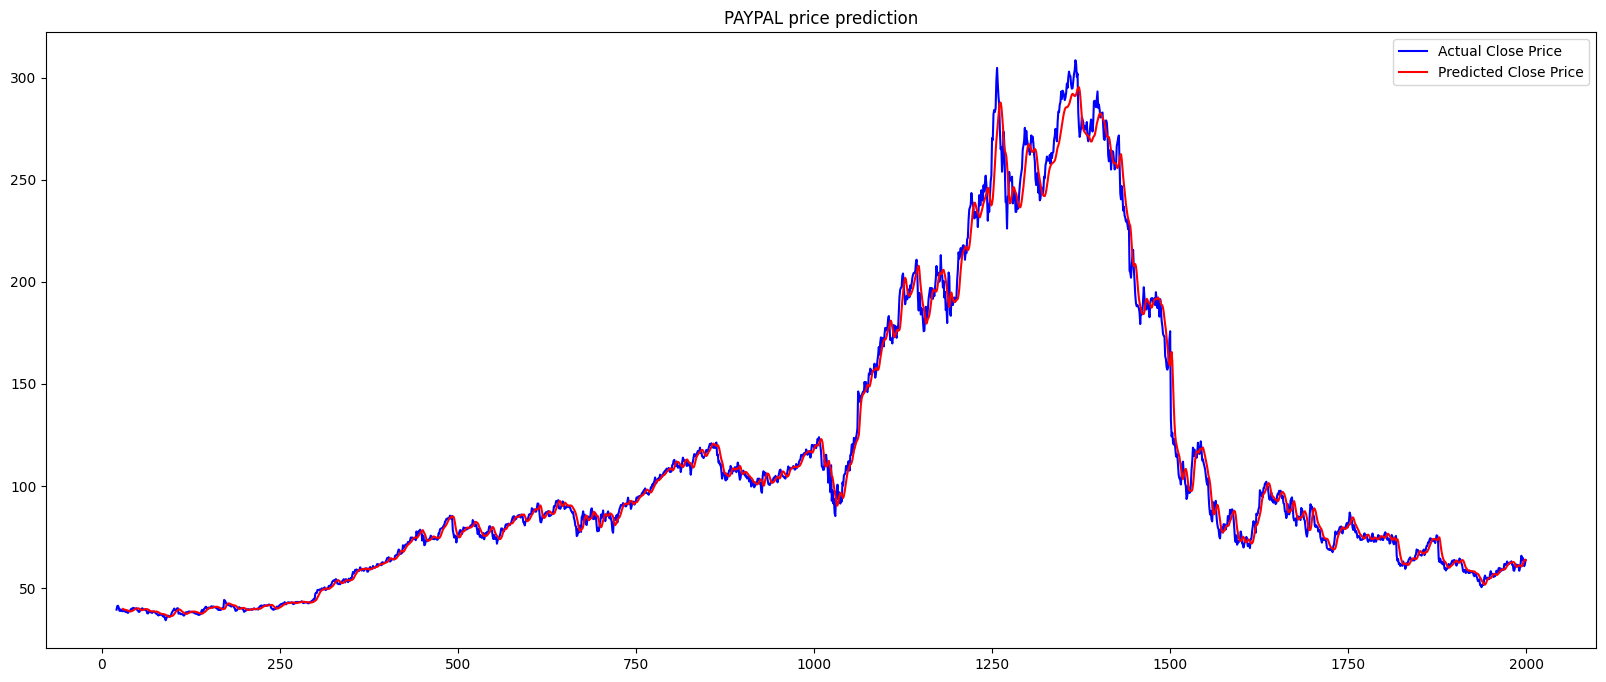

In [223]:
original = scaler.inverse_transform(paypal_price['close'].values.reshape(-1,1))
actuals = pd.DataFrame(original)
predictions = pd.DataFrame(y_test_pred_paypal)

#Plot predictions/actuals close price for test entries
valid['Actual'] = actuals
valid['Predictions'] = predictions
predictions.index = predictions.index + 30
plt.figure(figsize=(20,8))
plt.plot(np.exp(actuals[21:]), color = 'blue', label = 'Actual Close Price')
plt.plot(np.exp(predictions), color = 'red', label = 'Predicted Close Price')
plt.title('PAYPAL price prediction')
plt.legend()
plt.show()